## A Temperature Forecasting Example

Predicting the temperature 24 hours in the future.

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-28 21:45:54--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.144.77, 16.182.72.120, 16.182.97.32, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.144.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  28.4MB/s    in 0.5s    

2023-11-28 21:45:54 (28.4 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


#### 10.1 Inspecting the data of the Jena weather Dataset

In [1]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()
    
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


#### 10.2 Parsing the data

Now we need to convert into numpy arrays

In [2]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    # temperature will be our target
    temperature[i] = values[1]
    # all fields including temperature will be stored in raw data
    raw_data[i, :] = values[:]

#### 10.3 Plotting the temperature timeseries

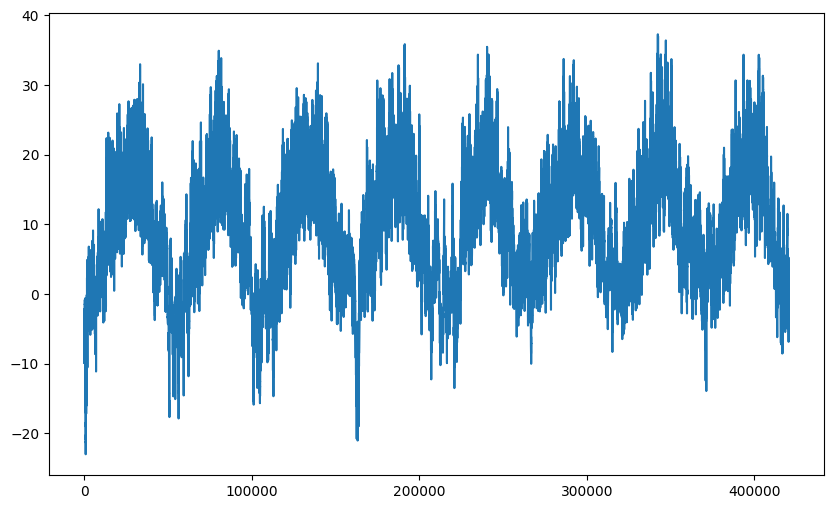

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
plt.plot(range(len(temperature)), temperature)

#### 10.4 Plotting the first 10 days of the temperature timeseries

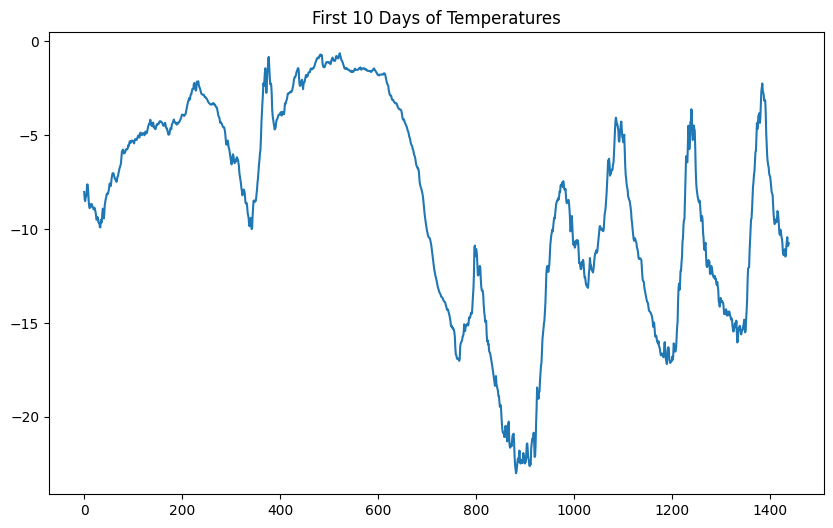

In [4]:
fig = plt.figure(figsize=(10, 6))
plt.title('First 10 Days of Temperatures')
plt.plot(range(1440), temperature[:1440])

#### 10.5 Computing the number of samples we'll use for each data split

In [5]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


#### 10.6 Normalizing the data

In [6]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

#### 10.7 Instantiating datasets for training, validation, and testing

In [8]:
from tensorflow import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


#### 10.9 Computing the commen-sense baseline MAE

In [14]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.0
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


#### 10.10 Training and evaluating a densely connected model

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks
                   )
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 13s 15ms/step - loss: 12.4363 - mae: 2.7334 - val_loss: 13.4938 - val_mae: 2.8785
Epoch 2/10
819/819 [==============================] - 13s 16ms/step - loss: 9.0428 - mae: 2.3673 - val_loss: 11.1731 - val_mae: 2.6356
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 8.3258 - mae: 2.2736 - val_loss: 11.9543 - val_mae: 2.7410
Epoch 4/10
819/819 [==============================] - 14s 17ms/step - loss: 7.8322 - mae: 2.2047 - val_loss: 11.1748 - val_mae: 2.6380
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 7.4576 - mae: 2.1503 - val_loss: 11.4636 - val_mae: 2.6769
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 7.2056 - mae: 2.1135 - val_loss: 10.3871 - val_mae: 2.5482
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 7.0130 - mae: 2.0835 - val_loss: 11.3195 - val_mae: 2.6653
Epoch 8/10
819/819 [==============================] - 

#### 10.11 Plotting Results

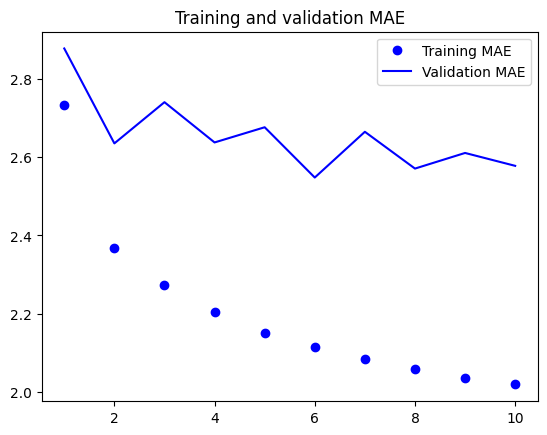

In [16]:
import matplotlib.pyplot as plt

loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training MAE')
plt.plot(epochs, val_loss, 'b', label='Validation MAE')
plt.title('Training and validation MAE')
plt.legend()
plt.show()

#### 10.2.4 Try a 1D convolutional model

In [18]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8 , 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint('jena_conv.keras', save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model('jena_conv.keras')
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 29s 34ms/step - loss: 24.4017 - mae: 3.8505 - val_loss: 14.8018 - val_mae: 3.0419
Epoch 2/10
819/819 [==============================] - 29s 35ms/step - loss: 15.7364 - mae: 3.1555 - val_loss: 13.8925 - val_mae: 2.9466
Epoch 3/10
819/819 [==============================] - 31s 38ms/step - loss: 14.2206 - mae: 2.9951 - val_loss: 16.8449 - val_mae: 3.2825
Epoch 4/10
819/819 [==============================] - 34s 41ms/step - loss: 13.0514 - mae: 2.8668 - val_loss: 14.6186 - val_mae: 3.0176
Epoch 5/10
819/819 [==============================] - 34s 41ms/step - loss: 12.2164 - mae: 2.7732 - val_loss: 15.3360 - val_mae: 3.0594
Epoch 6/10
819/819 [==============================] - 36s 44ms/step - loss: 11.6118 - mae: 2.7068 - val_loss: 14.7960 - val_mae: 3.0442
Epoch 7/10
819/819 [==============================] - 34s 42ms/step - loss: 11.1419 - mae: 2.6478 - val_loss: 16.1585 - val_mae: 3.1586
Epoch 8/10
819/819 [============================

#### 10.12 A simple LSTM-based model

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 9s 21ms/step - loss: 10.5021 - mae: 2.5245
Test MAE: 2.52


### 10.3 Understanding recurrent neural networks

Every model that we have seen so far has no memory. Each input is processed independently with no state kept between inputs. Since this is the architecture of these models they need to see the entire sequence at once to make a prediction.

Biological intelligence processes information incrementally while maintaining an internal model of what it's processing, built from past information and constantly updated as new information comes in.

RNN adopts the same principles by maintaining a state between sequences that contains relative information from the past sequences.

#### 10.13 Pseudocode RNN

state_t = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t

#### 10.15 NumPy implementation of a simple RNN

In [21]:
import numpy as np

timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t

final_output_sequence = np.stack(successive_outputs, axis=0)

An RNN is a for loop that reuses quantities computed during the previous iteration of the loop, nothing more.

#### 10.16 An RNN layer that can process sequences of any length

In [26]:
num_features = 14
# This can process sequences of different lengths
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

#### 10.17 An RNN layer that returns only its last output step

In [27]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


#### 10.18 An RNN layer that returns its full output sequence

In [28]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


#### 10.19 Stacking RNN layers

In [29]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

The big flaw with the SimpleRNN layer is the vanishing gradient problem. It cannot retain information from the inputs that were many timesteps ago.

#### 10.22 Training and evaluating a dropout-regularized LSTM

In [33]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# adding a dropout rate for the recurrent units
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
# dropout rate for the input units
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 93s 111ms/step - loss: 26.4863 - mae: 3.8042 - val_loss: 9.9842 - val_mae: 2.4692
Epoch 2/5
819/819 [==============================] - 83s 101ms/step - loss: 14.8463 - mae: 2.9856 - val_loss: 9.7545 - val_mae: 2.4415
Epoch 3/5
819/819 [==============================] - 92s 112ms/step - loss: 14.0247 - mae: 2.8973 - val_loss: 9.5242 - val_mae: 2.4076
Epoch 4/5
819/819 [==============================] - 99s 120ms/step - loss: 13.4226 - mae: 2.8351 - val_loss: 9.3298 - val_mae: 2.3873
Epoch 5/5
819/819 [==============================] - 95s 115ms/step - loss: 12.7852 - mae: 2.7675 - val_loss: 9.4074 - val_mae: 2.3905


#### 10.23 Training and evaluating a dropout-regularized, stacked GRU model

In [34]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
            keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                            save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")



Epoch 1/5
819/819 [==============================] - 177s 211ms/step - loss: 23.0874 - mae: 3.5773 - val_loss: 9.4707 - val_mae: 2.3798
Epoch 2/5
819/819 [==============================] - 168s 205ms/step - loss: 14.1625 - mae: 2.9195 - val_loss: 9.3617 - val_mae: 2.3919
Epoch 3/5
819/819 [==============================] - 169s 207ms/step - loss: 13.3605 - mae: 2.8332 - val_loss: 10.0173 - val_mae: 2.4623
Epoch 4/5
819/819 [==============================] - 157s 191ms/step - loss: 12.7421 - mae: 2.7679 - val_loss: 9.1120 - val_mae: 2.3537
Epoch 5/5
405/405 [==============================] - 16s 38ms/step - loss: 10.0793 - mae: 2.4912
Test MAE: 2.49


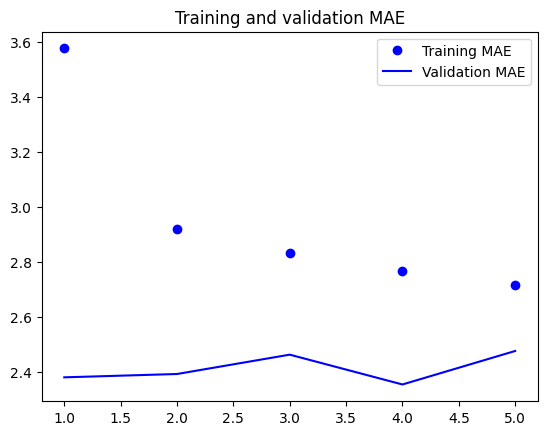

In [36]:
def plot_loss(history):
    loss = history.history['mae']
    val_loss = history.history['val_mae']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training MAE')
    plt.plot(epochs, val_loss, 'b', label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.legend()
    plt.show()

plot_loss(history)

#### 10.24 Training and evaluating a bidirectional LSTM

In [37]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 86s 96ms/step - loss: 27.8285 - mae: 3.7882 - val_loss: 10.3885 - val_mae: 2.4948
Epoch 2/10
819/819 [==============================] - 68s 83ms/step - loss: 9.7134 - mae: 2.4338 - val_loss: 9.8049 - val_mae: 2.4240
Epoch 3/10
819/819 [==============================] - 69s 84ms/step - loss: 8.8029 - mae: 2.3150 - val_loss: 9.6745 - val_mae: 2.4070
Epoch 4/10
819/819 [==============================] - 59s 72ms/step - loss: 8.3188 - mae: 2.2498 - val_loss: 9.7963 - val_mae: 2.4260
Epoch 5/10
819/819 [==============================] - 65s 80ms/step - loss: 7.9479 - mae: 2.1953 - val_loss: 9.7885 - val_mae: 2.4348
Epoch 6/10
819/819 [==============================] - 59s 72ms/step - loss: 7.6482 - mae: 2.1510 - val_loss: 10.1035 - val_mae: 2.4740
Epoch 7/10
819/819 [==============================] - 59s 72ms/step - loss: 7.3465 - mae: 2.1113 - val_loss: 10.0895 - val_mae: 2.4867
Epoch 8/10
819/819 [==============================] - 64s 